In [304]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

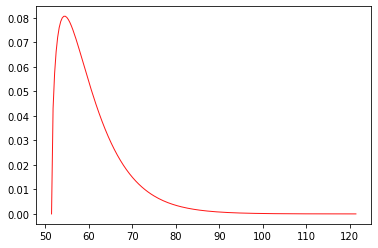

In [305]:
# distribution for the cost of BEP
loc = 51.42
mean = 60.42 - loc
a = 1.5
scale = mean/a
fig, ax = plt.subplots(1,1)
x = np.linspace(loc, loc+(120-50), 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
plt.show()

In [290]:
#file paths

output_dirs = ['/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/pakistan/2020_02_06_17_38_45/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/mali/2020_02_06_17_38_33/count_data/',
               '/share/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/tanzania/2020_02_06_17_39_16/count_data/'
              ]

locations = ['INDIA',
            'PAKISTAN',
            'MALI',
            'TANZANIA']

# YLLS and YLDs


In [272]:
#reading and exploring the YLL data table

ylls = pd.read_hdf('/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/ylls.hdf')
#ylls.where(ylls['input_draw']==3).dropna().head()

ylls.head()

#note: there are total of 56,000 rows (50 input draws)
#each input draw has 1120 rows which include: 5 age groups x 4 treatment groups x 2 mother nourishment status x 4 scenarios x 7 causes

,age_group,cause,treatment_group,mother_status,measure,input_draw,scenario,value
0,1_to_4,diarrheal_diseases,bep,malnourished,ylls,3,baseline,0.00000
1,1_to_4,diarrheal_diseases,bep,malnourished,ylls,3,bep_scale_up,259.31384
2,1_to_4,diarrheal_diseases,bep,malnourished,ylls,3,bep_targeted_scale_up,259.31384
3,1_to_4,diarrheal_diseases,bep,malnourished,ylls,3,mmn_scale_up,0.00000
4,1_to_4,diarrheal_diseases,bep,malnourished,ylls,21,baseline,0.00000


In [273]:
##gives summary information of the columns in the yll data table

#ylls['age_group'].describe() #unique =5
ylls['cause'].describe()  # unique=7


count            56000
unique               7
top       other_causes
freq              8000
Name: cause, dtype: object

In [274]:
#to look at the categories of each column variable:
ylls['age_group'].value_counts() #gives you counts of each value
#

1_to_4            11200
late_neonatal     11200
6mo_to_1          11200
early_neonatal    11200
1mo_to_6mo        11200
Name: age_group, dtype: int64

In [275]:
# YLL table by scenario and input draws: adding up the ylls across cause, age group, nourishment status, treatment group to get TOTAL Ylls by scenario. 
# -Must keep input draw groups (cannot sum over input draws, but need to avg)

ylls = (pd.read_hdf('/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/ylls.hdf')
    .groupby(['input_draw','scenario'])
    .sum()
    .reset_index()
    .rename(columns={'value':'ylls'})
)
ylls.head()    



,input_draw,scenario,ylls
0,3,baseline,232124.591300
1,3,bep_scale_up,213912.760439
2,3,bep_targeted_scale_up,225987.220608
3,3,mmn_scale_up,230454.856379
4,21,baseline,235581.574027


# Pandas subsetting using YLL table

test2 = ylls.copy()
test2 = test2.loc[:,:] # Keep everything
#test2 = test2.loc[:,['cause','treatment_group']] # All rows, subset columns
#test2 = test2.loc[(test2.input_draw==3) & (test2.age_group=='1_to_4'),:] # Subsetting rows
#test2 = test2.loc[test2.scenario.isin(['baseline','bep_scale_up']),:] # .isin() method
test2 = (test2.loc[test2.age_group=='1_to_4','mother_status']
            .drop_duplicates()
            .reset_index(drop=True) # Only unique combos of values
        )
test2.head(n=10)

In [182]:
#YLD table by scenario and input draws: adding up the ylds across cause, age group, nourishment status, treatment group to get TOTAL Ylls by scenario.
#- Must keep input draw groups (cannot sum over input draws, need to avg)

ylds = (pd.read_hdf('/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/ylds.hdf')
    .groupby(['input_draw','scenario'])
    .sum()
    .reset_index()
    .rename(columns={'value':'ylds'}) 
       )
        
ylds.head()

,input_draw,scenario,ylds
0,3,baseline,867.825898
1,3,bep_scale_up,696.517039
2,3,bep_targeted_scale_up,825.288223
3,3,mmn_scale_up,867.948603
4,21,baseline,1675.873202


# DALYS

In [183]:
#merge yll and yld tables
   
merge_yll_yld = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario']).reset_index()
merge_yll_yld.head()    

,index,input_draw,scenario,ylls,ylds
0,0,3,baseline,232124.591300,867.825898
1,1,3,bep_scale_up,213912.760439,696.517039
2,2,3,bep_targeted_scale_up,225987.220608,825.288223
3,3,3,mmn_scale_up,230454.856379,867.948603
4,4,21,baseline,235581.574027,1675.873202


In [184]:
# add column that is the sum of ylls and ylds columns
merge_yll_yld['dalys'] = merge_yll_yld['ylls'] + merge_yll_yld['ylds']
merge_yll_yld.head()

,index,input_draw,scenario,ylls,ylds,dalys
0,0,3,baseline,232124.591300,867.825898,232992.417198
1,1,3,bep_scale_up,213912.760439,696.517039,214609.277478
2,2,3,bep_targeted_scale_up,225987.220608,825.288223,226812.508831
3,3,3,mmn_scale_up,230454.856379,867.948603,231322.804982
4,4,21,baseline,235581.574027,1675.873202,237257.447229


In [185]:
#now can drop the yll and yld columns

dalys = merge_yll_yld.drop(columns=['ylls','ylds'])
dalys.head()

,index,input_draw,scenario,dalys
0,0,3,baseline,232992.417198
1,1,3,bep_scale_up,214609.277478
2,2,3,bep_targeted_scale_up,226812.508831
3,3,3,mmn_scale_up,231322.804982
4,4,21,baseline,237257.447229


# PERSON-TIME

In [186]:
#persontime table
person_time = pd.read_hdf('/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/person_time.hdf')
person_time.head()

#8000 rows and 7 columns


,age_group,treatment_group,mother_status,measure,input_draw,scenario,value
0,1_to_4,bep,malnourished,person_time,3,baseline,0.000000
1,1_to_4,bep,malnourished,person_time,3,bep_scale_up,13070.304586
2,1_to_4,bep,malnourished,person_time,3,bep_targeted_scale_up,13070.304586
3,1_to_4,bep,malnourished,person_time,3,mmn_scale_up,0.000000
4,1_to_4,bep,malnourished,person_time,21,baseline,0.000000


In [187]:
#person time per scenario

person_time = (pd.read_hdf('/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/person_time.hdf')
    .groupby(['input_draw','scenario'])
    .sum()
    .reset_index()
    .rename(columns={'value':'person_time'})
              )
person_time.head()

,input_draw,scenario,person_time
0,3,baseline,195352.413415
1,3,bep_scale_up,195690.069815
2,3,bep_targeted_scale_up,195475.419576
3,3,mmn_scale_up,195390.190281
4,21,baseline,195242.436687


# NUMBER TREATED

In [188]:
#Number of People, population.hdf, table

treatment_raw =pd.read_hdf('/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/population.hdf')


#2600 rows: 4 treatmentgroups x 2 mother_status x 50 input_draws x 4 scenarios = 1600 rows
#1000 rows: 5 measures x 4 scenarios x 50 input_draws = 1000 rows

In [189]:
#treatment['treatment_group'].value_counts() # =5
#treatment['measure'].value_counts() # =5
#treatment['scenario'].value_counts() # =4
treatment_raw['mother_status'].value_counts() # =3

all             1000
normal           800
malnourished     800
Name: mother_status, dtype: int64

In [190]:
#We need to get the number of people who got a treatment in each scenario. 
#We then multiply number treated by the cost of the treatment to compute total cost.

#exploring treatment table
treatmentraw_explore = treatment_raw.where(treatment_raw['input_draw'] == 3).dropna()
treatmentraw_explore.head()

,treatment_group,mother_status,measure,input_draw,scenario,value
0,all,all,total_population,3.0,baseline,100000.0
1,all,all,total_population,3.0,bep_scale_up,100000.0
2,all,all,total_population,3.0,bep_targeted_scale_up,100000.0
3,all,all,total_population,3.0,mmn_scale_up,100000.0
200,all,all,total_population_dead,3.0,baseline,2649.0


In [191]:
#to get number treated per scenario (collapsed over mother_status)

treatment_raw = (pd.read_hdf('/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/population.hdf')
        .groupby(['input_draw','scenario','treatment_group','measure'])
        .sum()
        .reset_index()
        .rename(columns={'value':'population'})
            )
        
treatment_raw.head()

,input_draw,scenario,treatment_group,measure,population
0,3,baseline,all,total_population,100000.0
1,3,baseline,all,total_population_dead,2649.0
2,3,baseline,all,total_population_living,97351.0
3,3,baseline,all,total_population_tracked,100000.0
4,3,baseline,all,total_population_untracked,0.0


In [192]:
treatment_raw.head()

,input_draw,scenario,treatment_group,measure,population
0,3,baseline,all,total_population,100000.0
1,3,baseline,all,total_population_dead,2649.0
2,3,baseline,all,total_population_living,97351.0
3,3,baseline,all,total_population_tracked,100000.0
4,3,baseline,all,total_population_untracked,0.0


In [193]:
treatmentraw_explore = treatment_raw.where(treatment_raw['input_draw'] == 3).dropna()
treatmentraw_explore.head()


,input_draw,scenario,treatment_group,measure,population
0,3.0,baseline,all,total_population,100000.0
1,3.0,baseline,all,total_population_dead,2649.0
2,3.0,baseline,all,total_population_living,97351.0
3,3.0,baseline,all,total_population_tracked,100000.0
4,3.0,baseline,all,total_population_untracked,0.0


In [194]:
treatmentraw_explore = treatment_raw.where(treatment_raw['scenario'] == 'baseline').dropna()
treatmentraw_explore.head(9)

,input_draw,scenario,treatment_group,measure,population
0,3.0,baseline,all,total_population,100000.0
1,3.0,baseline,all,total_population_dead,2649.0
2,3.0,baseline,all,total_population_living,97351.0
3,3.0,baseline,all,total_population_tracked,100000.0
4,3.0,baseline,all,total_population_untracked,0.0
5,3.0,baseline,bep,total_population,0.0
6,3.0,baseline,ifa,total_population,35116.0
7,3.0,baseline,mmn,total_population,0.0
8,3.0,baseline,none,total_population,64884.0


In [195]:
#drop other populations that are not total population counts in subgroups
treatmentraw_explore = treatment_raw.where(treatment_raw['measure'] == 'total_population').dropna()
treatmentraw_explore.head()

#50 input_draws x 4 scenarios x 5 treatment groups =1000 rows

,input_draw,scenario,treatment_group,measure,population
0,3.0,baseline,all,total_population,100000.0
5,3.0,baseline,bep,total_population,0.0
6,3.0,baseline,ifa,total_population,35116.0
7,3.0,baseline,mmn,total_population,0.0
8,3.0,baseline,none,total_population,64884.0


In [196]:
treatment_prep=treatment_raw.where(treatment_raw['measure']=='total_population').dropna()

In [197]:
#PIVOT table (treatment group rows to become columns)

#  dont need column measure anymore


treatment = pd.pivot_table(treatment_prep, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()

treatment.head(4)

#all column is the sum of all 5 'all' rows which is 300,000 (see output 306) and averaged over the 5 rows = 60,000

treatment_group,input_draw,scenario,all,bep,ifa,mmn,none
0,3.0,baseline,100000.0,0.0,35116.0,0.0,64884.0
1,3.0,bep_scale_up,100000.0,79620.0,0.0,0.0,20380.0
2,3.0,bep_targeted_scale_up,100000.0,13460.0,0.0,66160.0,20380.0
3,3.0,mmn_scale_up,100000.0,0.0,0.0,79620.0,20380.0


In [198]:
#renaming the columns
treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
treatment.head(4)

treatment_group,input_draw,scenario,total_population,bep_population,ifa_population,mmn_population,untreated_population
0,3.0,baseline,100000.0,0.0,35116.0,0.0,64884.0
1,3.0,bep_scale_up,100000.0,79620.0,0.0,0.0,20380.0
2,3.0,bep_targeted_scale_up,100000.0,13460.0,0.0,66160.0,20380.0
3,3.0,mmn_scale_up,100000.0,0.0,0.0,79620.0,20380.0


# Merge DALYs, TREATMENT TABLE

In [199]:
#merging treatment with dalys
dalys_tot = dalys.merge(treatment, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
dalys_tot.head()


,index,input_draw,scenario,dalys,total_population,bep_population,ifa_population,mmn_population,untreated_population
0,0,3,baseline,232992.417198,100000.0,0.0,35116.0,0.0,64884.0
1,1,3,bep_scale_up,214609.277478,100000.0,79620.0,0.0,0.0,20380.0
2,2,3,bep_targeted_scale_up,226812.508831,100000.0,13460.0,0.0,66160.0,20380.0
3,3,3,mmn_scale_up,231322.804982,100000.0,0.0,0.0,79620.0,20380.0
4,4,21,baseline,237257.447229,100000.0,0.0,39883.0,0.0,60117.0


In [200]:
#renaming table with dalys, person_time and number treated as count; as well as adding column name as India
count = dalys_tot
count['location'] = 'India'

count.head()

,index,input_draw,scenario,dalys,total_population,bep_population,ifa_population,mmn_population,untreated_population,location
0,0,3,baseline,232992.417198,100000.0,0.0,35116.0,0.0,64884.0,India
1,1,3,bep_scale_up,214609.277478,100000.0,79620.0,0.0,0.0,20380.0,India
2,2,3,bep_targeted_scale_up,226812.508831,100000.0,13460.0,0.0,66160.0,20380.0,India
3,3,3,mmn_scale_up,231322.804982,100000.0,0.0,0.0,79620.0,20380.0,India
4,4,21,baseline,237257.447229,100000.0,0.0,39883.0,0.0,60117.0,India


# DALYs averted

In [201]:
# dalys_tot: index	input_draw	scenario	dalys	total_population	bep_population	ifa_population	mmn_population	untreated_population

# COST 

In [202]:
dalys_tot.head()

,index,input_draw,scenario,dalys,total_population,bep_population,ifa_population,mmn_population,untreated_population,location
0,0,3,baseline,232992.417198,100000.0,0.0,35116.0,0.0,64884.0,India
1,1,3,bep_scale_up,214609.277478,100000.0,79620.0,0.0,0.0,20380.0,India
2,2,3,bep_targeted_scale_up,226812.508831,100000.0,13460.0,0.0,66160.0,20380.0,India
3,3,3,mmn_scale_up,231322.804982,100000.0,0.0,0.0,79620.0,20380.0,India
4,4,21,baseline,237257.447229,100000.0,0.0,39883.0,0.0,60117.0,India


In [203]:
#cost of BASELINE intervention
#-create new table with with baseline scenario only

dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna())
dalys_baseline['total_cost'] = 2.69 * dalys_baseline['ifa_population']
dalys_baseline.head()


,index,input_draw,scenario,dalys,total_population,bep_population,ifa_population,mmn_population,untreated_population,location,total_cost
0,0.0,3.0,baseline,232992.417198,100000.0,0.0,35116.0,0.0,64884.0,India,94462.04
4,4.0,21.0,baseline,237257.447229,100000.0,0.0,39883.0,0.0,60117.0,India,107285.27
8,8.0,29.0,baseline,262574.335890,100000.0,0.0,36459.0,0.0,63541.0,India,98074.71
12,12.0,55.0,baseline,231783.438944,100000.0,0.0,32813.0,0.0,67187.0,India,88266.97
16,16.0,78.0,baseline,204854.038084,100000.0,0.0,32607.0,0.0,67393.0,India,87712.83


In [204]:
#TABLE 1: BASELINE

dalys_baseline=dalys_baseline.drop(columns=['total_population','bep_population','ifa_population','mmn_population','untreated_population'])
dalys_baseline.head()


,index,input_draw,scenario,dalys,location,total_cost
0,0.0,3.0,baseline,232992.417198,India,94462.04
4,4.0,21.0,baseline,237257.447229,India,107285.27
8,8.0,29.0,baseline,262574.335890,India,98074.71
12,12.0,55.0,baseline,231783.438944,India,88266.97
16,16.0,78.0,baseline,204854.038084,India,87712.83


In [205]:
#cost of MMN_scale_up intervention
#-create new table with with mmn scenario

dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna())
dalys_mmn['total_cost'] = 3.69 * dalys_mmn['mmn_population']
dalys_mmn.head()

,index,input_draw,scenario,dalys,total_population,bep_population,ifa_population,mmn_population,untreated_population,location,total_cost
3,3.0,3.0,mmn_scale_up,231322.804982,100000.0,0.0,0.0,79620.0,20380.0,India,293797.80
7,7.0,21.0,mmn_scale_up,234182.179580,100000.0,0.0,0.0,79260.0,20740.0,India,292469.40
11,11.0,29.0,mmn_scale_up,260465.377327,100000.0,0.0,0.0,79586.0,20414.0,India,293672.34
15,15.0,55.0,mmn_scale_up,230465.726684,100000.0,0.0,0.0,79244.0,20756.0,India,292410.36
19,19.0,78.0,mmn_scale_up,203184.774443,100000.0,0.0,0.0,79380.0,20620.0,India,292912.20


In [206]:
#TABLE 2: MMN_scale_up

dalys_mmn=dalys_mmn.drop(columns=['total_population','bep_population','ifa_population','mmn_population','untreated_population'])
dalys_mmn.head()


,index,input_draw,scenario,dalys,location,total_cost
3,3.0,3.0,mmn_scale_up,231322.804982,India,293797.80
7,7.0,21.0,mmn_scale_up,234182.179580,India,292469.40
11,11.0,29.0,mmn_scale_up,260465.377327,India,293672.34
15,15.0,55.0,mmn_scale_up,230465.726684,India,292410.36
19,19.0,78.0,mmn_scale_up,203184.774443,India,292912.20


In [207]:
#cost of BEP_scale_up (universal) intervention
#-create new table with with bep_scale_up scenario

dalys_bep = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_scale_up').dropna())
dalys_bep['total_cost'] = 10 * dalys_bep['bep_population'] 
dalys_bep.head()     

dalys_bep.head() #50 rows

,index,input_draw,scenario,dalys,total_population,bep_population,ifa_population,mmn_population,untreated_population,location,total_cost
1,1.0,3.0,bep_scale_up,214609.277478,100000.0,79620.0,0.0,0.0,20380.0,India,796200.0
5,5.0,21.0,bep_scale_up,216705.675933,100000.0,79260.0,0.0,0.0,20740.0,India,792600.0
9,9.0,29.0,bep_scale_up,242408.071290,100000.0,79586.0,0.0,0.0,20414.0,India,795860.0
13,13.0,55.0,bep_scale_up,214096.523347,100000.0,79244.0,0.0,0.0,20756.0,India,792440.0
17,17.0,78.0,bep_scale_up,188428.912555,100000.0,79380.0,0.0,0.0,20620.0,India,793800.0


In [208]:
#TABLE 3: BEP_scale_up universal 

dalys_bep=dalys_bep.drop(columns=['total_population','bep_population','ifa_population','mmn_population','untreated_population'])
dalys_bep.head()

,index,input_draw,scenario,dalys,location,total_cost
1,1.0,3.0,bep_scale_up,214609.277478,India,796200.0
5,5.0,21.0,bep_scale_up,216705.675933,India,792600.0
9,9.0,29.0,bep_scale_up,242408.071290,India,795860.0
13,13.0,55.0,bep_scale_up,214096.523347,India,792440.0
17,17.0,78.0,bep_scale_up,188428.912555,India,793800.0


In [209]:
#cost of BEP_targeted_scale_up intervention
#-create new table with with bep_scale_up scenario

dalys_bep_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_targeted_scale_up').dropna())

dalys_bep_targeted['total_cost'] = 10 * dalys_bep_targeted['bep_population'] + 3.69 * dalys_bep_targeted['mmn_population']
dalys_bep_targeted.head()


,index,input_draw,scenario,dalys,total_population,bep_population,ifa_population,mmn_population,untreated_population,location,total_cost
2,2.0,3.0,bep_targeted_scale_up,226812.508831,100000.0,13460.0,0.0,66160.0,20380.0,India,378730.40
6,6.0,21.0,bep_targeted_scale_up,228765.354538,100000.0,13977.0,0.0,65283.0,20740.0,India,380664.27
10,10.0,29.0,bep_targeted_scale_up,254410.939586,100000.0,12054.0,0.0,67532.0,20414.0,India,369733.08
14,14.0,55.0,bep_targeted_scale_up,226176.506055,100000.0,12955.0,0.0,66289.0,20756.0,India,374156.41
18,18.0,78.0,bep_targeted_scale_up,197906.124697,100000.0,14442.0,0.0,64938.0,20620.0,India,384041.22


In [210]:
#TABLE 4: BEP_targeted_scale_up targeted 

dalys_bep_targeted=dalys_bep_targeted.drop(columns=['total_population','bep_population','ifa_population','mmn_population','untreated_population'])
dalys_bep_targeted.head()

,index,input_draw,scenario,dalys,location,total_cost
2,2.0,3.0,bep_targeted_scale_up,226812.508831,India,378730.40
6,6.0,21.0,bep_targeted_scale_up,228765.354538,India,380664.27
10,10.0,29.0,bep_targeted_scale_up,254410.939586,India,369733.08
14,14.0,55.0,bep_targeted_scale_up,226176.506055,India,374156.41
18,18.0,78.0,bep_targeted_scale_up,197906.124697,India,384041.22


# We have now 4 data-sets with the total costs of the inverventions: 
# dalys_baseline: which has total daly's in baseline and total baseline cost
# dalys_mmn: which has total dalys in MMN and total MMN cost
# dalys_bep: which has total dalys in bep universal and total bep universal cost
# dalys_bep_targeted: which has total dalys in bep_targeted and total    bep_targeted cost


In [211]:
#MMN and baseline
dalys_scenarios1 = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'],
                        left_on=['input_draw'], suffixes=['_baseline','_mmn'])
dalys_scenarios1.head()



,index_baseline,input_draw,scenario_baseline,dalys_baseline,location_baseline,total_cost_baseline,index_mmn,scenario_mmn,dalys_mmn,location_mmn,total_cost_mmn
0,0.0,3.0,baseline,232992.417198,India,94462.04,3.0,mmn_scale_up,231322.804982,India,293797.80
1,4.0,21.0,baseline,237257.447229,India,107285.27,7.0,mmn_scale_up,234182.179580,India,292469.40
2,8.0,29.0,baseline,262574.335890,India,98074.71,11.0,mmn_scale_up,260465.377327,India,293672.34
3,12.0,55.0,baseline,231783.438944,India,88266.97,15.0,mmn_scale_up,230465.726684,India,292410.36
4,16.0,78.0,baseline,204854.038084,India,87712.83,19.0,mmn_scale_up,203184.774443,India,292912.20


In [212]:
#daly's baseline and bep universal

dalys_scenarios2 = dalys_baseline.merge(dalys_bep, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep'])
dalys_scenarios2.head()

#why doesnt it suffix total_cost_1?!!!

,index_baseline,input_draw,scenario_baseline,dalys_baseline,location_baseline,total_cost_baseline,index_bep,scenario_bep,dalys_bep,location_bep,total_cost_bep
0,0.0,3.0,baseline,232992.417198,India,94462.04,1.0,bep_scale_up,214609.277478,India,796200.0
1,4.0,21.0,baseline,237257.447229,India,107285.27,5.0,bep_scale_up,216705.675933,India,792600.0
2,8.0,29.0,baseline,262574.335890,India,98074.71,9.0,bep_scale_up,242408.071290,India,795860.0
3,12.0,55.0,baseline,231783.438944,India,88266.97,13.0,bep_scale_up,214096.523347,India,792440.0
4,16.0,78.0,baseline,204854.038084,India,87712.83,17.0,bep_scale_up,188428.912555,India,793800.0


In [213]:
#daly's baseline and bep targeted

dalys_scenarios3 = dalys_baseline.merge(dalys_bep_targeted, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep_targeted'])

dalys_scenarios3.head()

,index_baseline,input_draw,scenario_baseline,dalys_baseline,location_baseline,total_cost_baseline,index_bep_targeted,scenario_bep_targeted,dalys_bep_targeted,location_bep_targeted,total_cost_bep_targeted
0,0.0,3.0,baseline,232992.417198,India,94462.04,2.0,bep_targeted_scale_up,226812.508831,India,378730.40
1,4.0,21.0,baseline,237257.447229,India,107285.27,6.0,bep_targeted_scale_up,228765.354538,India,380664.27
2,8.0,29.0,baseline,262574.335890,India,98074.71,10.0,bep_targeted_scale_up,254410.939586,India,369733.08
3,12.0,55.0,baseline,231783.438944,India,88266.97,14.0,bep_targeted_scale_up,226176.506055,India,374156.41
4,16.0,78.0,baseline,204854.038084,India,87712.83,18.0,bep_targeted_scale_up,197906.124697,India,384041.22


In [214]:
dalys_scenarios4 = dalys_scenarios1.merge(dalys_scenarios2, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
dalys_scenarios4.head()

,index_baseline,input_draw,scenario_baseline,dalys_baseline,location_baseline,total_cost_baseline,index_mmn,scenario_mmn,dalys_mmn,location_mmn,...,index_baseline_drop,scenario_baseline_drop,dalys_baseline_drop,location_baseline_drop,total_cost_baseline_drop,index_bep,scenario_bep,dalys_bep,location_bep,total_cost_bep
0,0.0,3.0,baseline,232992.417198,India,94462.04,3.0,mmn_scale_up,231322.804982,India,...,0.0,baseline,232992.417198,India,94462.04,1.0,bep_scale_up,214609.277478,India,796200.0
1,4.0,21.0,baseline,237257.447229,India,107285.27,7.0,mmn_scale_up,234182.179580,India,...,4.0,baseline,237257.447229,India,107285.27,5.0,bep_scale_up,216705.675933,India,792600.0
2,8.0,29.0,baseline,262574.335890,India,98074.71,11.0,mmn_scale_up,260465.377327,India,...,8.0,baseline,262574.335890,India,98074.71,9.0,bep_scale_up,242408.071290,India,795860.0
3,12.0,55.0,baseline,231783.438944,India,88266.97,15.0,mmn_scale_up,230465.726684,India,...,12.0,baseline,231783.438944,India,88266.97,13.0,bep_scale_up,214096.523347,India,792440.0
4,16.0,78.0,baseline,204854.038084,India,87712.83,19.0,mmn_scale_up,203184.774443,India,...,16.0,baseline,204854.038084,India,87712.83,17.0,bep_scale_up,188428.912555,India,793800.0


In [215]:
dalys_scenarios_all = dalys_scenarios4.merge(dalys_scenarios3, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
dalys_scenarios_all.head()

,index_baseline,input_draw,scenario_baseline,dalys_baseline,location_baseline,total_cost_baseline,index_mmn,scenario_mmn,dalys_mmn,location_mmn,...,index_baseline_drop,scenario_baseline_drop,dalys_baseline_drop,location_baseline_drop,total_cost_baseline_drop,index_bep_targeted,scenario_bep_targeted,dalys_bep_targeted,location_bep_targeted,total_cost_bep_targeted
0,0.0,3.0,baseline,232992.417198,India,94462.04,3.0,mmn_scale_up,231322.804982,India,...,0.0,baseline,232992.417198,India,94462.04,2.0,bep_targeted_scale_up,226812.508831,India,378730.40
1,4.0,21.0,baseline,237257.447229,India,107285.27,7.0,mmn_scale_up,234182.179580,India,...,4.0,baseline,237257.447229,India,107285.27,6.0,bep_targeted_scale_up,228765.354538,India,380664.27
2,8.0,29.0,baseline,262574.335890,India,98074.71,11.0,mmn_scale_up,260465.377327,India,...,8.0,baseline,262574.335890,India,98074.71,10.0,bep_targeted_scale_up,254410.939586,India,369733.08
3,12.0,55.0,baseline,231783.438944,India,88266.97,15.0,mmn_scale_up,230465.726684,India,...,12.0,baseline,231783.438944,India,88266.97,14.0,bep_targeted_scale_up,226176.506055,India,374156.41
4,16.0,78.0,baseline,204854.038084,India,87712.83,19.0,mmn_scale_up,203184.774443,India,...,16.0,baseline,204854.038084,India,87712.83,18.0,bep_targeted_scale_up,197906.124697,India,384041.22


In [216]:
dalys_scenarios_raw = dalys_scenarios_all.drop(columns=[c for c in dalys_scenarios_all.columns if 'drop' in c])

dalys_scenarios_raw.head()

,index_baseline,input_draw,scenario_baseline,dalys_baseline,location_baseline,total_cost_baseline,index_mmn,scenario_mmn,dalys_mmn,location_mmn,...,index_bep,scenario_bep,dalys_bep,location_bep,total_cost_bep,index_bep_targeted,scenario_bep_targeted,dalys_bep_targeted,location_bep_targeted,total_cost_bep_targeted
0,0.0,3.0,baseline,232992.417198,India,94462.04,3.0,mmn_scale_up,231322.804982,India,...,1.0,bep_scale_up,214609.277478,India,796200.0,2.0,bep_targeted_scale_up,226812.508831,India,378730.40
1,4.0,21.0,baseline,237257.447229,India,107285.27,7.0,mmn_scale_up,234182.179580,India,...,5.0,bep_scale_up,216705.675933,India,792600.0,6.0,bep_targeted_scale_up,228765.354538,India,380664.27
2,8.0,29.0,baseline,262574.335890,India,98074.71,11.0,mmn_scale_up,260465.377327,India,...,9.0,bep_scale_up,242408.071290,India,795860.0,10.0,bep_targeted_scale_up,254410.939586,India,369733.08
3,12.0,55.0,baseline,231783.438944,India,88266.97,15.0,mmn_scale_up,230465.726684,India,...,13.0,bep_scale_up,214096.523347,India,792440.0,14.0,bep_targeted_scale_up,226176.506055,India,374156.41
4,16.0,78.0,baseline,204854.038084,India,87712.83,19.0,mmn_scale_up,203184.774443,India,...,17.0,bep_scale_up,188428.912555,India,793800.0,18.0,bep_targeted_scale_up,197906.124697,India,384041.22


In [217]:
dalys_scenario=dalys_scenarios_raw.drop(columns=['location_mmn','location_baseline','location_bep_targeted','location_bep','scenario_baseline','scenario_mmn','scenario_bep','scenario_bep_targeted'])
dalys_scenario['location'] = 'India'

dalys_scenario.head()

,index_baseline,input_draw,dalys_baseline,total_cost_baseline,index_mmn,dalys_mmn,total_cost_mmn,index_bep,dalys_bep,total_cost_bep,index_bep_targeted,dalys_bep_targeted,total_cost_bep_targeted,location
0,0.0,3.0,232992.417198,94462.04,3.0,231322.804982,293797.80,1.0,214609.277478,796200.0,2.0,226812.508831,378730.40,India
1,4.0,21.0,237257.447229,107285.27,7.0,234182.179580,292469.40,5.0,216705.675933,792600.0,6.0,228765.354538,380664.27,India
2,8.0,29.0,262574.335890,98074.71,11.0,260465.377327,293672.34,9.0,242408.071290,795860.0,10.0,254410.939586,369733.08,India
3,12.0,55.0,231783.438944,88266.97,15.0,230465.726684,292410.36,13.0,214096.523347,792440.0,14.0,226176.506055,374156.41,India
4,16.0,78.0,204854.038084,87712.83,19.0,203184.774443,292912.20,17.0,188428.912555,793800.0,18.0,197906.124697,384041.22,India


# ICERS

In [218]:
# DAlYs averted and COST difference: mmn vs baseline
dalys_scenario['dalys_averted_mmn'] = dalys_scenario['dalys_mmn'] - dalys_scenario['dalys_baseline']
dalys_scenario['cost_averted_mmn'] = dalys_scenario['total_cost_mmn'] - dalys_scenario['total_cost_baseline']

dalys_scenario.head()

,index_baseline,input_draw,dalys_baseline,total_cost_baseline,index_mmn,dalys_mmn,total_cost_mmn,index_bep,dalys_bep,total_cost_bep,index_bep_targeted,dalys_bep_targeted,total_cost_bep_targeted,location,dalys_averted_mmn,cost_averted_mmn
0,0.0,3.0,232992.417198,94462.04,3.0,231322.804982,293797.80,1.0,214609.277478,796200.0,2.0,226812.508831,378730.40,India,-1669.612215,199335.76
1,4.0,21.0,237257.447229,107285.27,7.0,234182.179580,292469.40,5.0,216705.675933,792600.0,6.0,228765.354538,380664.27,India,-3075.267648,185184.13
2,8.0,29.0,262574.335890,98074.71,11.0,260465.377327,293672.34,9.0,242408.071290,795860.0,10.0,254410.939586,369733.08,India,-2108.958563,195597.63
3,12.0,55.0,231783.438944,88266.97,15.0,230465.726684,292410.36,13.0,214096.523347,792440.0,14.0,226176.506055,374156.41,India,-1317.712260,204143.39
4,16.0,78.0,204854.038084,87712.83,19.0,203184.774443,292912.20,17.0,188428.912555,793800.0,18.0,197906.124697,384041.22,India,-1669.263641,205199.37


In [219]:
# DAlYs averted and COST difference: bep universal vs baseline

dalys_scenario['dalys_averted_bep'] = dalys_scenario['dalys_bep'] - dalys_scenario['dalys_baseline']
dalys_scenario['cost_averted_bep'] = dalys_scenario['total_cost_bep'] - dalys_scenario['total_cost_baseline']
   

In [220]:
# DAlYs averted and COST difference: bep targeted vs baseline

dalys_scenario['dalys_averted_bep_targeted'] = dalys_scenario['dalys_bep_targeted'] - dalys_scenario['dalys_baseline']
dalys_scenario['cost_averted_bep_targeted'] = dalys_scenario['total_cost_bep_targeted'] - dalys_scenario['total_cost_baseline']
   


In [221]:
#DALYs averted and COST difference: bep universal vs mmn

dalys_scenario['dalys_averted_bep_rel_to_mmn'] = dalys_scenario['dalys_bep'] - dalys_scenario['dalys_mmn']
dalys_scenario['cost_averted_bep_rel_to_mmn'] = dalys_scenario['total_cost_bep'] - dalys_scenario['total_cost_mmn']

In [222]:
#DALYs averted and COST difference: bep targeted vs mmn

dalys_scenario['dalys_averted_bep_targeted_rel_to_mmn'] = dalys_scenario['dalys_bep_targeted'] - dalys_scenario['dalys_mmn']
dalys_scenario['cost_averted_bep_targeted_rel_to_mmn'] = dalys_scenario['total_cost_bep_targeted'] - dalys_scenario['total_cost_mmn']


In [223]:
#ICER: cost difference/dalys averted

dalys_scenario['icer_mmn'] = dalys_scenario['cost_averted_mmn'] / dalys_scenario['dalys_averted_mmn']
dalys_scenario['icer_bep'] = dalys_scenario['cost_averted_bep'] / dalys_scenario['dalys_averted_bep']
dalys_scenario['icer_bep_targeted'] = dalys_scenario['cost_averted_bep_targeted'] / dalys_scenario['dalys_averted_bep_targeted']
    
dalys_scenario['icer_bep_rel_to_mmn'] = dalys_scenario['cost_averted_bep_rel_to_mmn'] / dalys_scenario['dalys_averted_bep_rel_to_mmn']
dalys_scenario['icer_bep_targeted_rel_to_mmn'] = dalys_scenario['cost_averted_bep_targeted_rel_to_mmn'] / dalys_scenario['dalys_averted_bep_targeted_rel_to_mmn']

dalys_scenario.head()

,index_baseline,input_draw,dalys_baseline,total_cost_baseline,index_mmn,dalys_mmn,total_cost_mmn,index_bep,dalys_bep,total_cost_bep,...,cost_averted_bep_targeted,dalys_averted_bep_rel_to_mmn,cost_averted_bep_rel_to_mmn,dalys_averted_bep_targeted_rel_to_mmn,cost_averted_bep_targeted_rel_to_mmn,icer_mmn,icer_bep,icer_bep_targeted,icer_bep_rel_to_mmn,icer_bep_targeted_rel_to_mmn
0,0.0,3.0,232992.417198,94462.04,3.0,231322.804982,293797.80,1.0,214609.277478,796200.0,...,284268.36,-16713.527504,502402.20,-4510.296151,84932.60,-119.390454,-38.172911,-45.998799,-30.059615,-18.830826
1,4.0,21.0,237257.447229,107285.27,7.0,234182.179580,292469.40,5.0,216705.675933,792600.0,...,273379.00,-17476.503648,500130.60,-5416.825043,88194.87,-60.217240,-33.345774,-32.192183,-28.617314,-16.281654
2,8.0,29.0,262574.335890,98074.71,11.0,260465.377327,293672.34,9.0,242408.071290,795860.0,...,271658.37,-18057.306037,502187.66,-6054.437741,76060.74,-92.746075,-34.601613,-33.277616,-27.810774,-12.562808
3,12.0,55.0,231783.438944,88266.97,15.0,230465.726684,292410.36,13.0,214096.523347,792440.0,...,285889.44,-16369.203338,500029.64,-4289.220629,81746.05,-154.922585,-39.813218,-50.988561,-30.546975,-19.058486
4,16.0,78.0,204854.038084,87712.83,19.0,203184.774443,292912.20,17.0,188428.912555,793800.0,...,296328.39,-14755.861888,500887.80,-5278.649746,91129.02,-122.928077,-42.988236,-42.649983,-33.945005,-17.263699


In [224]:
dalys_prep = dalys_scenario.reset_index().drop(columns=['input_draw','index_baseline'])
dalys_mean = pd.DataFrame(dalys_prep.mean())
dalys_min = pd.DataFrame(dalys_prep.quantile(0.025))
dalys_max = pd.DataFrame(dalys_prep.quantile(0.975))
    
per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True)
   
per_pt1
    

,0.0,0.025
index,24.500000,1.225000
dalys_baseline,235388.175360,218314.786564
total_cost_baseline,91545.219200,85205.212000
index_mmn,101.000000,7.900000
dalys_mmn,233219.592196,216001.320348
total_cost_mmn,293051.313000,291134.265750
index_bep,99.000000,5.900000
dalys_bep,217414.615678,202390.181988
total_cost_bep,794177.000000,788981.750000
index_bep_targeted,100.000000,6.900000


In [225]:
#per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True)
final_per_pt = per_pt1.merge(dalys_max, right_index=True, left_index=True)#, suffixes=['','_drop'])
final_per_pt = final_per_pt.rename(columns={0.0:'mean', 0.025:'min', 0.975:'max'})#.drop(columns='0.0_mean_drop')
final_per_pt = final_per_pt.reset_index()
final_per_pt['location'] = 'India'

final_per_pt.head()


,index,mean,min,max,location
0,index,24.500000,1.225000,47.775000,India
1,dalys_baseline,235388.175360,218314.786564,261610.195002,India
2,total_cost_baseline,91545.219200,85205.212000,102864.591250,India
3,index_mmn,101.000000,7.900000,194.100000,India
4,dalys_mmn,233219.592196,216001.320348,259481.559713,India


In [226]:
#ICER
final_per_pt.where(final_per_pt['index'].str.contains('icer')).where(final_per_pt['location'] == 'India').dropna()

,index,mean,min,max,location
22,icer_mmn,-100.520359,-181.116949,-60.521956,India
23,icer_bep,-39.668109,-50.510411,-32.289959,India
24,icer_bep_targeted,-39.871839,-53.709507,-29.795336,India
25,icer_bep_rel_to_mmn,-32.207672,-41.959749,-26.632332,India
26,icer_bep_targeted_rel_to_mmn,-16.799692,-24.387691,-12.592131,India


# ALL TOGETHER NOW

In [329]:
#DALYs

master_avg = pd.DataFrame()
master_draws = pd.DataFrame()
master_counts = pd.DataFrame()

for i in list(range(0,4)):
    ylls = pd.read_hdf(output_dirs[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylls'})
    ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylds'})
    dalys = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys['dalys'] = dalys['ylls'] + dalys['ylds']
    dalys = dalys.drop(columns=['ylls','ylds'])
    person_time = pd.read_hdf(output_dirs[i] + 'person_time.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'person_time'})
    treatment = pd.read_hdf(output_dirs[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
    treatment = treatment.where(treatment['measure'] == 'total_population').dropna()
    treatment = pd.pivot_table(treatment, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()
    treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
    
    dalys_pt = dalys.merge(person_time, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    dalys_tot = dalys_pt.merge(treatment, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    count = dalys_tot
    count['location'] = locations[i]
    master_counts = master_counts.append(count)

    # add cost data
    dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna().drop(columns='scenario'))
    dalys_baseline['cost'] = 2.69 * dalys_baseline['ifa_population'] 
    
    
    dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna().drop(columns='scenario'))
    dalys_mmn['cost'] = 3.69 * dalys_mmn['mmn_population'] 
  

    dalys_bep = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep['cost'] = dalys_bep['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep['person_time'])) 
    dalys_bep['cost_bep_avg'] = 60.42 * dalys_bep['bep_population'] 
    dalys_bep['cost_bep_low'] = 51.42 * dalys_bep['bep_population'] 
    dalys_bep['cost_bep_high'] = 120.42 * dalys_bep['bep_population'] 
    dalys_bep = dalys_bep.drop(columns='person_time')
    
    dalys_bep_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_targeted_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep_targeted['cost'] = (dalys_bep_targeted['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_targeted['person_time']))+ dalys_bep_targeted['mmn_population'] * 3.69)
    dalys_bep_targeted['cost_bep_targeted_avg'] = (60.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted['cost_bep_targeted_low'] = (51.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted['cost_bep_targeted_high'] = (120.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted = dalys_bep_targeted.drop(columns='person_time')
    
    
    dalys_scenarios1 = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_mmn'])
    dalys_scenarios2 = dalys_baseline.merge(dalys_bep, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep'])
    dalys_scenarios3 = dalys_baseline.merge(dalys_bep_targeted, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep_targeted'])
    dalys_scenarios4 = dalys_scenarios1.merge(dalys_scenarios2, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios4.merge(dalys_scenarios3, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios.drop(columns=[c for c in dalys_scenarios.columns if 'drop' in c])

    dalys_scenarios['dalys_averted_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_mmn'] = dalys_scenarios['cost_mmn'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep_targeted'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep_targeted'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_baseline']
    
    #dalys_scenarios['cost_averted_bep_avg'] = dalys_scenarios['cost_bep_avg'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_low'] = dalys_scenarios['cost_bep_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_high'] = dalys_scenarios['cost_bep_high'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_low'] = dalys_scenarios['cost_bep_targeted_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_high'] = dalys_scenarios['cost_bep_targeted_high'] - dalys_scenarios['cost_baseline']

    dalys_scenarios['cost_averted_bep_rel_to_mmn'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['dalys_averted_bep_rel_to_mmn'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['dalys_bep']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_bep']

    dalys_scenarios['icer_mmn'] = dalys_scenarios['cost_averted_mmn'] / dalys_scenarios['dalys_averted_mmn']
    dalys_scenarios['icer_bep'] = dalys_scenarios['cost_averted_bep'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted'] = dalys_scenarios['cost_averted_bep_targeted'] / dalys_scenarios['dalys_averted_bep_targeted']
        
    dalys_scenarios['icer_bep_low'] = dalys_scenarios['cost_averted_bep_low'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_high'] = dalys_scenarios['cost_averted_bep_high'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted_low'] = dalys_scenarios['cost_averted_bep_targeted_low'] / dalys_scenarios['dalys_averted_bep_targeted']
    dalys_scenarios['icer_bep_targeted_high'] = dalys_scenarios['cost_averted_bep_targeted_high'] / dalys_scenarios['dalys_averted_bep_targeted']
    
    dalys_scenarios['icer_bep_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep']
    
    dalys_scenarios = dalys_scenarios.set_index(['input_draw'])
    
    dalys_scenarios['location'] = locations[i]
    master_draws = master_draws.append(dalys_scenarios.reset_index())
        
    dalys_prep = dalys_scenarios.reset_index().drop(columns=['input_draw','person_time'])
    dalys_mean = pd.DataFrame(dalys_prep.mean())
    dalys_min = pd.DataFrame(dalys_prep.quantile(0.025))
    dalys_max = pd.DataFrame(dalys_prep.quantile(0.975))
    
    per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True)
    #per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True)
    final_per_pt = per_pt1.merge(dalys_max, right_index=True, left_index=True)#, suffixes=['','_drop'])
    final_per_pt = final_per_pt.rename(columns={0.0:'mean', 0.025:'min', 0.975:'max'})#.drop(columns='0.0_mean_drop')
    final_per_pt = final_per_pt.reset_index()
    final_per_pt['location'] = locations[i]
    master_avg = master_avg.append(final_per_pt)

master_avg.head()

,index,mean,min,max,location
0,dalys_baseline,235388.175360,218314.786564,261610.195002,INDIA
1,person_time_baseline,195323.112389,194796.047707,195698.958795,INDIA
2,total_population_baseline,100000.000000,100000.000000,100000.000000,INDIA
3,bep_population_baseline,0.000000,0.000000,0.000000,INDIA
4,ifa_population_baseline,34031.680000,31674.800000,38239.625000,INDIA


In [330]:
master_avg.where(master_avg['index'].str.contains('population')).where(master_avg['location'] == 'INDIA').dropna()

,index,mean,min,max,location
2,total_population_baseline,100000.00,100000.000,100000.000,INDIA
3,bep_population_baseline,0.00,0.000,0.000,INDIA
4,ifa_population_baseline,34031.68,31674.800,38239.625,INDIA
5,mmn_population_baseline,0.00,0.000,0.000,INDIA
6,untreated_population_baseline,65968.32,61760.375,68325.200,INDIA
10,total_population_mmn,100000.00,100000.000,100000.000,INDIA
11,bep_population_mmn,0.00,0.000,0.000,INDIA
12,ifa_population_mmn,0.00,0.000,0.000,INDIA
13,mmn_population_mmn,79417.70,78898.175,79836.300,INDIA
14,untreated_population_mmn,20582.30,20163.700,21101.825,INDIA


In [331]:
master_avg.where(master_avg['index'].str.contains('cost_bep')).where(master_avg['location'] == 'INDIA').dropna()

,index,mean,min,max,location
22,cost_bep,4.886358e+06,4.174382e+06,6.571559e+06,INDIA
23,cost_bep_avg,4.798417e+06,4.767028e+06,4.823709e+06,INDIA
24,cost_bep_low,4.083658e+06,4.056944e+06,4.105183e+06,INDIA
25,cost_bep_high,9.563479e+06,9.500918e+06,9.613887e+06,INDIA
32,cost_bep_targeted,1.071307e+06,9.181538e+05,1.351619e+06,INDIA
33,cost_bep_targeted_avg,1.055859e+06,9.935476e+05,1.130068e+06,INDIA
34,cost_bep_targeted_low,9.348423e+05,8.824516e+05,9.972172e+05,INDIA
35,cost_bep_targeted_high,1.862636e+06,1.734188e+06,2.015737e+06,INDIA


In [322]:
master_avg.where(master_avg['index'].str.contains('bep_targeted')).where(master_avg['location'] == 'INDIA').dropna()

,index,mean,min,max,location
21,dalys_bep_targeted,228008.358701,211268.673918,253785.988620,INDIA
22,total_population_bep_targeted,100000.000000,100000.000000,100000.000000,INDIA
23,bep_population_bep_targeted,13446.280000,12344.000000,14761.150000,INDIA
24,ifa_population_bep_targeted,0.000000,0.000000,0.000000,INDIA
25,mmn_population_bep_targeted,65971.420000,64547.375000,67331.700000,INDIA
26,untreated_population_bep_targeted,20582.300000,20163.700000,21101.825000,INDIA
27,cost_bep_targeted,340247.755800,336401.851500,344534.530500,INDIA
34,dalys_averted_bep_targeted,7379.816660,5326.097269,9777.404850,INDIA
35,cost_averted_bep_targeted,248702.536600,235067.748250,259099.665500,INDIA
36,icer_bep_targeted_rel_to_baseline,34.639023,25.657525,46.838539,INDIA


In [231]:
#ICER
master_avg.where(master_avg['index'].str.contains('icer_bep')).where(master_avg['location'] == 'India').dropna()

,index,mean,min,max,location
39,icer_bep_universal_rel_to_baseline,270.687393,221.162252,342.564132,India
40,icer_bep_targeted_rel_to_baseline,136.175296,102.866485,181.715603,India
41,icer_bep_universal_rel_to_mmn,295.231128,244.124853,384.623387,India
42,icer_bep_targeted_rel_to_mmn,153.994112,115.425574,223.549393,India


In [316]:
np.random.seed(12345)
value = scipy.stats.gamma.rvs(a, loc, scale, size=50)
print(value.mean())                                       


61.53051680102007


In [314]:
print(13446.28*61.53051680102007 + 3.69*65971.42)

1070791.0972512201


# Loop for cost

In [319]:
master_avg = pd.DataFrame()
master_draws = pd.DataFrame()
master_counts = pd.DataFrame()

for i in list(range(0,4)):
     
    ylls = (pd.read_hdf(output_dirs[i] + 'ylls.hdf')
          .groupby(['input_draw','scenario']).sum().reset_index().rename(columns={'value':'ylls'}))
    ylds = (pd.read_hdf(output_dirs[i] + 'ylds.hdf')
          .groupby(['input_draw','scenario']).sum().reset_index().rename(columns={'value':'ylds'}))
    dalys = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys['dalys'] = dalys['ylls'] + dalys['ylds']
    dalys = dalys.drop(columns=['ylls','ylds'])
   
    treatment = pd.read_hdf(output_dirs[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
    treatment = treatment.where(treatment['measure'] == 'total_population').dropna()
    treatment = pd.pivot_table(treatment, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()
    treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
    
    dalys_tot = dalys.merge(treatment, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    dalys_tot.head()   

    count = dalys_tot
    count['location'] = locations[i]
    master_counts = master_counts.append(count)

    # add cost data
    #baseline dalys and cost
    dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna().drop(columns='scenario'))
    dalys_baseline['cost'] = 2.69 * dalys_baseline['ifa_population'] 
    
    #mmn dalys and cost
    dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna().drop(columns='scenario'))
    dalys_mmn['cost'] = 3.69 * dalys_mmn['mmn_population'] 
  
    #BEP universal dalys and universal cost
    
    bep_cost = 5.00
    icer_bep_universal_rel_to_baseline=0
    cost_target = 25
    
    while icer_bep_universal_rel_to_baseline < cost_target:
        
        dalys_bep_universal = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_scale_up').dropna().drop(columns='scenario'))
        dalys_bep_universal['cost'] = bep_cost * dalys_bep['bep_population'] 
     
        #BEP targeted dalys and cost
        dalys_bep_targeted = (pd.DataFrame
                      .copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_targeted_scale_up')
                      .dropna().drop(columns='scenario')))
        dalys_bep_targeted['cost'] = (bep_cost * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69)

        dalys_scenarios1 = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'],
                                 left_on=['input_draw'], suffixes=['_baseline','_mmn'])
        dalys_scenarios2 = dalys_baseline.merge(dalys_bep_universal, right_on=['input_draw'],
                                 left_on=['input_draw'], suffixes=['_baseline','_bep'])
        dalys_scenarios3 = dalys_baseline.merge(dalys_bep_targeted, right_on=['input_draw'],
                                 left_on=['input_draw'], suffixes=['_baseline','_bep_targeted'])
        dalys_scenarios4 = dalys_scenarios1.merge(dalys_scenarios2, right_on=['input_draw'],
                                 left_on=['input_draw'], suffixes=['','_drop'])
        dalys_scenarios = dalys_scenarios4.merge(dalys_scenarios3, right_on=['input_draw'],
                                 left_on=['input_draw'], suffixes=['','_drop'])
        dalys_scenarios = dalys_scenarios.drop(columns=[c for c in dalys_scenarios.columns if 'drop' in c])

        #ICERS
        #mmn vs baseline
        dalys_scenarios['cost_averted_mmn'] = dalys_scenarios['cost_mmn'] - dalys_scenarios['cost_baseline']
        dalys_scenarios['dalys_averted_mmn'] = dalys_scenarios['dalys_baseline'] - dalys_scenarios['dalys_mmn']
        dalys_scenarios['icer_mmn_rel_to_baseline'] = dalys_scenarios['cost_averted_mmn'] / dalys_scenarios['dalys_averted_mmn']
        
        #bep universal vs baseline
        dalys_scenarios['cost_averted_bep_universal'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_baseline']
        dalys_scenarios['dalys_averted_bep_universal'] = dalys_scenarios['dalys_baseline'] - dalys_scenarios['dalys_bep']
        dalys_scenarios['icer_bep_universal_rel_to_baseline'] = dalys_scenarios['cost_averted_bep_universal'] / dalys_scenarios['dalys_averted_bep_universal']
        
        #bep targeted vs baseline
        dalys_scenarios['dalys_averted_bep_targeted'] = dalys_scenarios['dalys_baseline'] - dalys_scenarios['dalys_bep_targeted']
        dalys_scenarios['cost_averted_bep_targeted'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_baseline']
        dalys_scenarios['icer_bep_targeted_rel_to_baseline'] = dalys_scenarios['cost_averted_bep_targeted'] / dalys_scenarios['dalys_averted_bep_targeted']
            
        #bep universal vs. mmn
        dalys_scenarios['cost_averted_bep_rel_to_mmn'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_mmn']
        dalys_scenarios['dalys_averted_bep_rel_to_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_bep']
        dalys_scenarios['icer_bep_universal_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_rel_to_mmn']


        #bep targeted vs mmn
        dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_mmn']
        dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_bep_targeted']
        dalys_scenarios['icer_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn']

        dalys_scenarios = dalys_scenarios.set_index(['input_draw'])

        dalys_scenarios['location'] = locations[i]
        
        dalys_prep = dalys_scenarios.reset_index().drop(columns=['input_draw'])
        dalys_mean = pd.DataFrame(dalys_prep.mean())
        dalys_min = pd.DataFrame(dalys_prep.quantile(0.025))
        dalys_max = pd.DataFrame(dalys_prep.quantile(0.975))

        per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True)

        #per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True)
        final_per_pt = per_pt1.merge(dalys_max, right_index=True, left_index=True)#, suffixes=['','_drop'])
        final_per_pt = final_per_pt.rename(columns={0.0:'mean', 0.025:'min', 0.975:'max'})#.drop(columns='0.0_mean_drop')
        final_per_pt = final_per_pt.reset_index()
        final_per_pt['location'] = locations[i]
        
        #ICER
        icer_bep_universal_rel_to_baseline = final_per_pt.loc[final_per_pt['index']=='icer_bep_universal_rel_to_baseline','mean'].iloc[0]
        bep_population_bep = final_per_pt.loc[final_per_pt['index']=='bep_population_bep','mean'].iloc[0]
        dalys_averted_bep_universal = final_per_pt.loc[final_per_pt['index']=='dalys_averted_bep_universal','mean'].iloc[0]
        cost_averted_bep_universal = final_per_pt.loc[final_per_pt['index']=='cost_averted_bep_universal','mean'].iloc[0]
        cost_baseline=final_per_pt.loc[final_per_pt['index']=='cost_baseline','mean'].iloc[0]
        
        if icer_bep_universal_rel_to_baseline < cost_target:
            bep_cost=bep_cost + 0.10
        
    print(locations[i])
    print('bep cost=', bep_cost)
    print('numbers treated=', bep_population_bep)
    print('cost difference=', cost_averted_bep_universal)
    print('dalys averted=', dalys_averted_bep_universal)
    print('icer =', icer_bep_universal_rel_to_baseline)
            
    master_draws = master_draws.append(dalys_scenarios.reset_index())
    master_avg = master_avg.append(final_per_pt)


INDIA
bep cost= 7.199999999999992
numbers treated= 79417.7
cost difference= 449490.1407999994
dalys averted= 17973.559682209787
icer = 25.369586443155853
PAKISTAN
bep cost= 8.799999999999986
numbers treated= 75941.5
cost difference= 594771.491399999
dalys averted= 24095.233848332464
icer = 25.296366475571464
MALI
bep cost= 10.999999999999979
numbers treated= 75143.8
cost difference= 763906.9519999982
dalys averted= 30961.566312197494
icer = 25.176469197549633
TANZANIA
bep cost= 7.3999999999999915
numbers treated= 88484.88
cost difference= 499652.3989999994
dalys averted= 20623.39965088828
icer = 25.05839824380777


In [295]:
#master_avg.where(master_avg['location'] == 'TANZANIA').dropna()